## Import Libraries

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from tqdm import tqdm
import gdown
import zipfile
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

## Load Dataset

In [31]:
url = "https://drive.google.com/uc?id=1D9vwXug5KMlBC39W7U6yMISCMtamAsUt"
output = "dataset.zip"

gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("../dataset")

os.remove(output)

Downloading...
From (original): https://drive.google.com/uc?id=1D9vwXug5KMlBC39W7U6yMISCMtamAsUt
From (redirected): https://drive.google.com/uc?id=1D9vwXug5KMlBC39W7U6yMISCMtamAsUt&confirm=t&uuid=9535316c-68df-4982-9db0-9b488af86443
To: c:\Users\Randy Verdian\Documents\Coding\deep-learning\brain-tumor-classification\notebook\dataset.zip
100%|██████████| 156M/156M [00:12<00:00, 12.3MB/s] 


## Preprocessing

In [12]:
# Data augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), 
])

# Create instances of the custom dataset
train_dataset = datasets.ImageFolder("../dataset/Training", transform=transform)
test_dataset = datasets.ImageFolder("../dataset/Testing", transform=transform)

# Split training data into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Get class labels
classes = train_dataset.dataset.classes
print("Classes:", classes)

# Print dataset sizes
print(f"Training Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}, Testing Samples: {len(test_dataset)}")

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training Samples: 4569, Validation Samples: 1143, Testing Samples: 1311


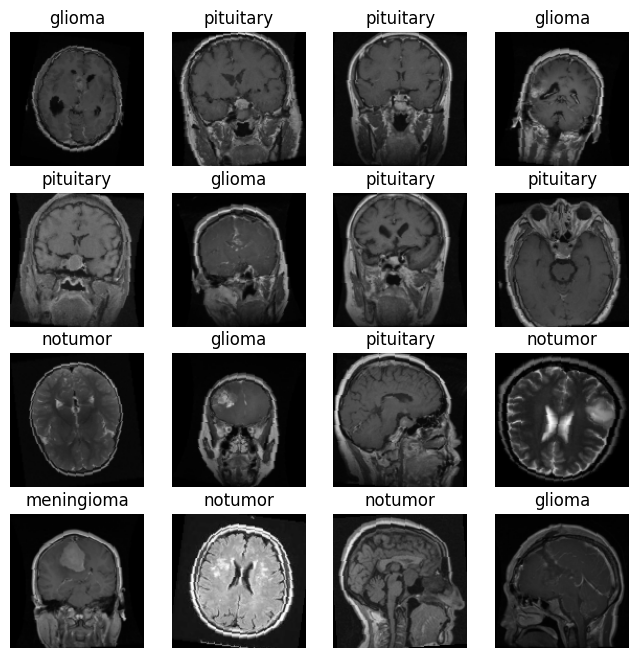

In [13]:
# Display images
def show_images(images, labels):
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))
show_images(images, labels)

## Define Model

In [14]:
class TumorClassifierCNN(nn.Module):
    def __init__(self):
        super(TumorClassifierCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, len(classes)) 
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [15]:
model = TumorClassifierCNN()
print(model)

TumorClassifierCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=32768, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=4, bias=True)
  )
)


## Training Preparation

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TumorClassifierCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience):
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    early_stop = False

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), '../model/best_model.pth')
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Early stopping triggered. Stopping training.")
            early_stop = True
            break

    if early_stop:
        model.load_state_dict(torch.load('../model/best_model.pth'))
        print("Loaded best model based on validation loss.")

    plot_training_history(train_losses, val_losses, val_accuracies)
    
    return model

def plot_training_history(train_losses, val_losses, val_accuracies):
    epochs = len(train_losses)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot Loss
    axs[0].plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
    axs[0].plot(range(1, epochs+1), val_losses, label='Val Loss', color='red')
    axs[0].set_title('Loss over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    # Plot Accuracy
    axs[1].plot(range(1, epochs+1), val_accuracies, label='Val Accuracy', color='green')
    axs[1].set_title('Validation Accuracy over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

Epoch [1/30], Train Loss: 0.7739, Val Loss: 0.4969, Val Accuracy: 79.44%


Epoch [2/30], Train Loss: 0.5253, Val Loss: 0.3915, Val Accuracy: 84.51%


Epoch [3/30], Train Loss: 0.4145, Val Loss: 0.3559, Val Accuracy: 86.09%


Epoch [4/30], Train Loss: 0.3547, Val Loss: 0.2983, Val Accuracy: 88.19%


Epoch [5/30], Train Loss: 0.3020, Val Loss: 0.2261, Val Accuracy: 91.43%


Epoch [6/30], Train Loss: 0.2797, Val Loss: 0.2241, Val Accuracy: 92.13%


Epoch [7/30], Train Loss: 0.2531, Val Loss: 0.2177, Val Accuracy: 92.13%


Epoch [8/30], Train Loss: 0.2242, Val Loss: 0.1738, Val Accuracy: 93.26%


Epoch [9/30], Train Loss: 0.1791, Val Loss: 0.1754, Val Accuracy: 93.09%


Epoch [10/30], Train Loss: 0.1725, Val Loss: 0.1779, Val Accuracy: 93.88%


Epoch [11/30], Train Loss: 0.1373, Val Loss: 0.1273, Val Accuracy: 95.63%


Epoch [12/30], Train Loss: 0.1344, Val Loss: 0.1392, Val Accuracy: 95.80%


Epoch [13/30], Train Loss: 0.1210, Val Loss: 0.1388, Val Accuracy: 95.36%


Epoch [14/30], Train Loss: 0.1170, Val Loss: 0.1514, Val Accuracy: 95.19%
Early stopping triggered. Stopping training.
Loaded best model based on validation loss.


C:\Users\Randy Verdian\AppData\Local\Temp\ipykernel_7860\1378518706.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../model/best_mode

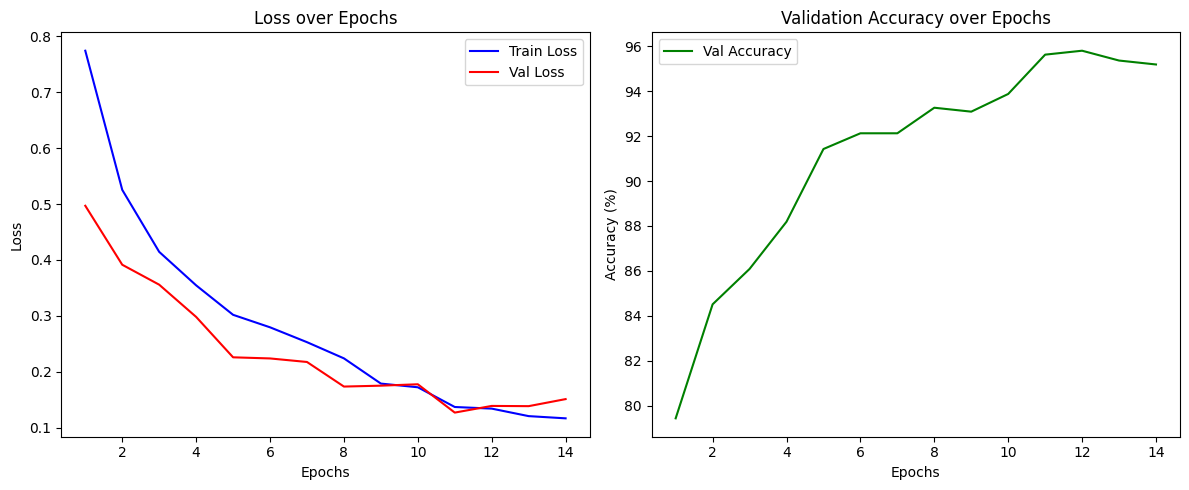

In [19]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=30, patience=3)

## Evaluation

In [20]:
def imshow(image, label, pred):
    npimage = image.numpy().transpose((1, 2, 0))
    return npimage

In [48]:
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * (sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels))
precision = precision_score(all_labels, all_predictions, average='weighted') * 100
recall = recall_score(all_labels, all_predictions, average='weighted') * 100
f1 = f1_score(all_labels, all_predictions, average='weighted') * 100

print("\nEvaluation Results:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-score: {f1:.2f}%")


Evaluation Results:
Accuracy: 93.90%
Precision: 94.03%
Recall: 93.90%
F1-score: 93.90%


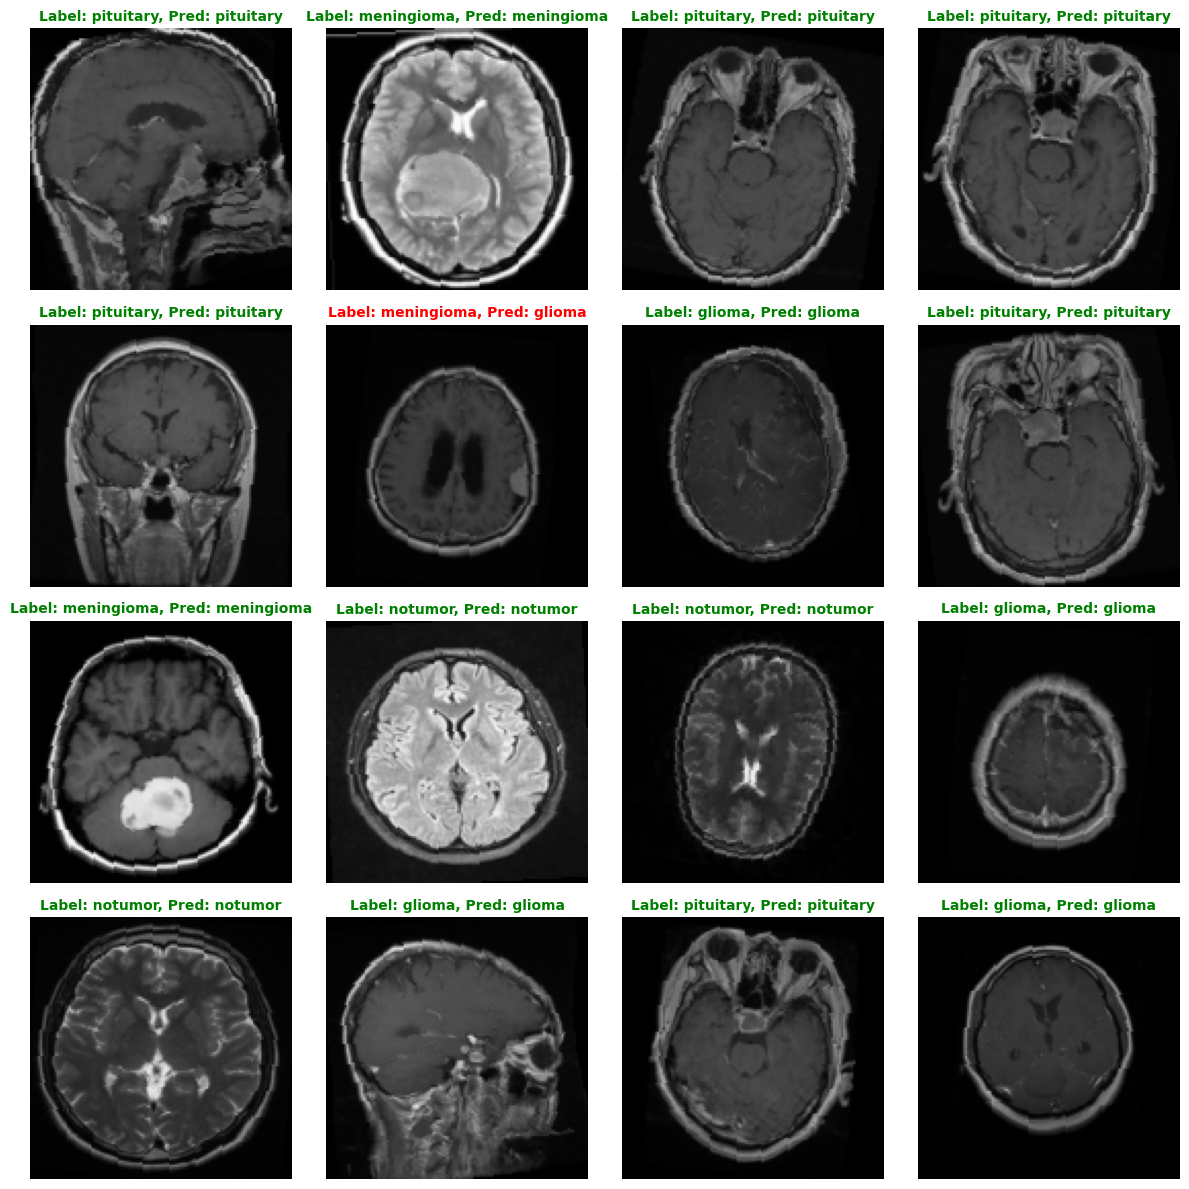

In [27]:
images, labels = next(iter(test_loader))
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i in range(16):
    npimage = imshow(images[i], labels[i], predicted[i].item())
    axes[i].imshow(npimage)

    if predicted[i] == labels[i]:
        color = 'green'
    else:
        color = 'red'
    
    axes[i].set_title(f"Label: {classes[labels[i]]}, Pred: {classes[predicted[i]]}", color=color, fontsize=10, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [28]:
class_correct = [0] * len(classes)
class_total = [0] * len(classes)

model.eval()

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Calculating per class accuracy"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print(f'Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]:.2f}%')

Calculating per class accuracy: 100%|██████████| 41/41 [00:14<00:00,  2.80it/s]

Accuracy of glioma : 87.00%
Accuracy of meningioma : 87.58%
Accuracy of notumor : 97.78%
Accuracy of pituitary : 99.00%


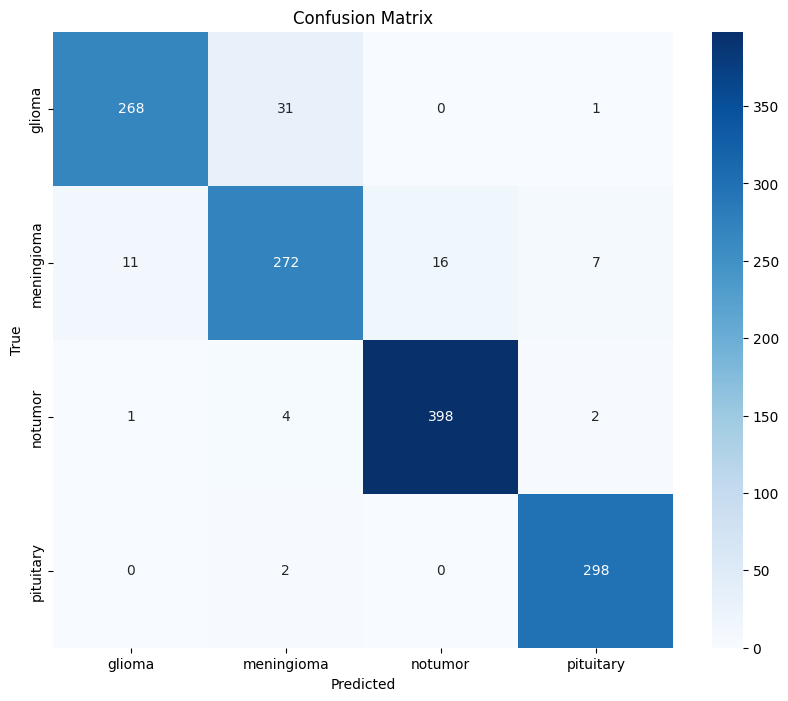

In [ ]:
all_labels = []
all_preds = []

model.eval()

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Collecting predictions"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()